In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from modules import data_loader, metrics, learning, plotting, utils, params, pipelines
from modules.gmp_model import GMP
import matplotlib.pyplot as plt
import numpy as np
import torch


Load data from files and init acpr meter

In [16]:
data = data_loader.load_data("DPA_200MHz")

config = data["config"]
fs = config["input_signal_fs"]
bw_main_ch = config["bw_main_ch"]
bw_sub_ch = config["bw_sub_ch"]
n_sub_ch = config["n_sub_ch"]
sub_ch = config["sub_ch"]
nperseg = config["nperseg"]

x_train = data["train_input"]
y_train = data["train_output"]
x_val = data["val_input"]
y_val = data["val_output"]

gain = metrics.calculate_gain_complex(x_train, y_train)
print(f"Gain of PA = {gain:.2f}")
y_train_target = gain * x_train
y_val_target = gain * x_val

data['y_train_target'] = y_train_target
data['y_val_target'] = y_val_target


acpr_meter = metrics.ACPR(
        sample_rate=fs,
        main_measurement_bandwidth=bw_main_ch,
        adjacent_channel_offset=[-sub_ch, sub_ch],
        segment_length=nperseg,
        overlap_percentage=60,
        window='blackmanharris',
        fft_length=nperseg,
        power_units='dBW',
        return_main_power=True,
        return_adjacent_powers=True
    )


Gain of PA = 2.52


PA model

In [20]:
pa_train_loader = [(x_train, y_train)]
pa_val_loader = [(x_val, y_val)]
criterion = metrics.compute_mse
metric_criterion = metrics.compute_nmse

pa_degree = 5
pa_config = params.make_gmp_params(
    Ka=pa_degree,
    La=pa_degree,
    Kb=pa_degree,
    Lb=pa_degree,
    Mb=pa_degree,
    Kc=pa_degree,
    Lc=pa_degree,
    Mc=pa_degree,
)

pa_model = GMP(**pa_config, model_name="pa")

epochs = 10000
lr = 0.001

optimizer = torch.optim.Adam(pa_model.parameters(), lr=lr)

if not pa_model.load_weights():
      learning.train(net=pa_model, 
            criterion=criterion, 
            optimizer=optimizer, 
            train_loader=pa_train_loader, 
            val_loader=pa_val_loader, 
            n_epochs=epochs, 
            metric_criterion=metric_criterion)
      pa_model.save_weights()
utils.freeze_pa_model(pa_model)

y_val_pa = learning.net_inference(net=pa_model, x=x_val)
pa_nmse = metrics.compute_nmse(y_val_pa, y_val)
print(f"Model NMSE: {pa_nmse:.2f}")

Coefficients loaded from model_params/pa_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
Model NMSE: -32.98


In [23]:
pa_model.count_params()

275

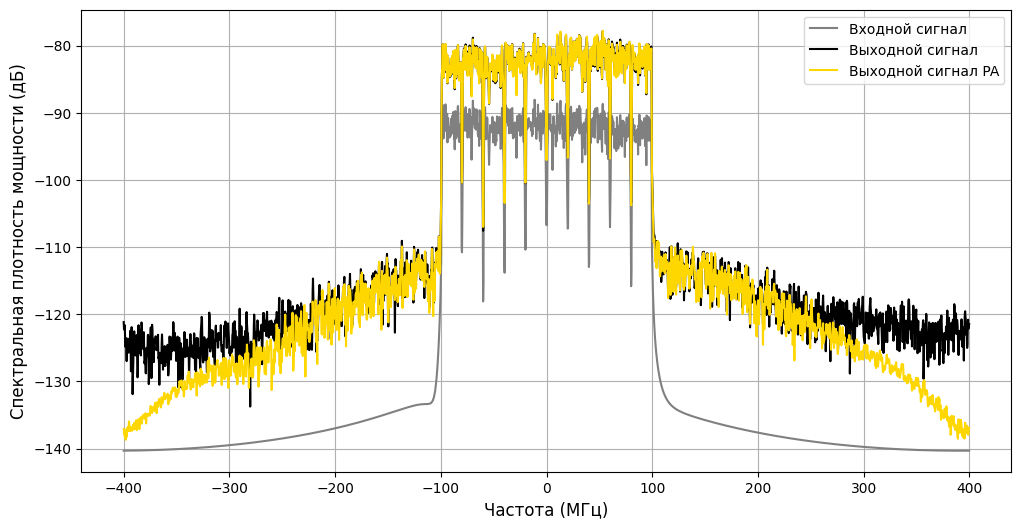

In [24]:
freqs, spectrum_y_in = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_val_pa = metrics.power_spectrum(y_val_pa, fs, nperseg)

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_out)), color='black', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_pa)), color='gold', label='Выходной сигнал PA')

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


DLA DPD grad

In [25]:
dla_train_loader = [(x_train, y_train_target)]
dla_val_loader = [(x_val, y_val_target)]

epochs = 1000
lr = 0.001

dla_degree = 5
dla_config = params.make_gmp_params(
    Ka=dla_degree,
    La=dla_degree,
    Kb=dla_degree,
    Lb=dla_degree,
    Mb=dla_degree,
    Kc=dla_degree,
    Lc=dla_degree,
    Mc=dla_degree,
)
dpd_model_dla = GMP(**dla_config, model_name="dla")
is_load = dpd_model_dla.load_weights()
casc_dla = utils.CascadeModel(model_1=dpd_model_dla, model_2=pa_model, cascade_type="dla")

optimizer_dla = torch.optim.Adam(casc_dla.parameters(), lr=lr)

if not is_load:
    learning.train(net=casc_dla, 
                   criterion=criterion, 
                   optimizer=optimizer_dla, 
                   train_loader=dla_train_loader, 
                   val_loader=dla_val_loader, 
                   grad_clip_val=0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    dpd_model_dla.save_weights()

y_val_dla = learning.net_inference(net=casc_dla, x=x_val)
nmse_dla = metrics.compute_nmse(y_val_dla, y_val_target)
print(f"Model NMSE: {nmse_dla:.2f}")



Coefficients loaded from model_params/dla_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
Model NMSE: -49.59


ILA DPD grad

In [26]:
ila_train_loader = [(x_train, x_train)]
ila_val_loader = [(x_val, x_val)]

epochs = 1000
lr = 0.001

ila_degree = 5
ila_config = params.make_gmp_params(
    Ka=ila_degree,
    La=ila_degree,
    Kb=ila_degree,
    Lb=ila_degree,
    Mb=ila_degree,
    Kc=ila_degree,
    Lc=ila_degree,
    Mc=ila_degree,
)
dpd_model_ila = GMP(**ila_config, model_name="ila")

is_load = dpd_model_ila.load_weights()
casc_ila_train = utils.CascadeModel(model_2=dpd_model_ila, model_1=pa_model, gain=gain, cascade_type="ila")
casc_ila_eval = utils.CascadeModel(model_1=dpd_model_ila, model_2=pa_model)

optimizer = torch.optim.Adam(casc_ila_train.parameters(), lr=lr)

if not is_load:
    learning.train(net=casc_ila_train, 
                   criterion=criterion, 
                   optimizer=optimizer, 
                   train_loader=ila_train_loader, 
                   val_loader=ila_val_loader, 
                   grad_clip_val=0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    dpd_model_ila.save_weights()

y_val_ila = learning.net_inference(net=casc_ila_eval, x=x_val)
nmse_ila = metrics.compute_nmse(y_val_ila, y_val_target)
print(f"Model NMSE: {nmse_ila:.2f}")


Coefficients loaded from model_params/ila_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
Model NMSE: -47.57


ILC DPD grad

In [27]:
u_k_train = learning.ilc_signal(x_train, y_train_target, pa_model, epochs=1000, learning_rate=0.001)
u_k_val = learning.ilc_signal(x_val, y_val_target, pa_model, epochs=1000, learning_rate=0.001)
u_k_pa = pa_model.forward(u_k_train).detach()

data["ilc_train_output"] = u_k_train
data["ilc_val_output"] = u_k_val

ilc_train_loader = [(x_train, u_k_train)]
ilc_val_loader = [(x_val, u_k_val)]

Epoch [0/1000], Loss: 0.030477918684482574
Epoch [100/1000], Loss: 0.0010683428263291717
Epoch [200/1000], Loss: 2.9619668566738255e-05
Epoch [300/1000], Loss: 6.954932700864447e-07
Epoch [400/1000], Loss: 3.9306566890218164e-08
Epoch [500/1000], Loss: 1.1716266179462309e-08
Epoch [600/1000], Loss: 7.97405075303459e-09
Epoch [700/1000], Loss: 6.854731893213284e-09
Epoch [800/1000], Loss: 6.308487510153782e-09
Epoch [900/1000], Loss: 6.004321040364857e-09
Epoch [999/1000], Loss: 5.8344444830993325e-09
Время расчёта ilc_signal: 0:02:38
Epoch [0/1000], Loss: 0.03021436184644699
Epoch [100/1000], Loss: 0.0010643481509760022
Epoch [200/1000], Loss: 3.04563782265177e-05
Epoch [300/1000], Loss: 7.428039339174575e-07
Epoch [400/1000], Loss: 5.5598114556687506e-08
Epoch [500/1000], Loss: 1.7859653311802504e-08
Epoch [600/1000], Loss: 9.977293657925657e-09
Epoch [700/1000], Loss: 7.113897915189682e-09
Epoch [800/1000], Loss: 5.698900462647316e-09
Epoch [900/1000], Loss: 4.886136828474719e-09
Epo

In [29]:
epochs = 1000
lr = 0.001

ilc_degree = 5
ilc_config = params.make_gmp_params(
    Ka=ilc_degree,
    La=ilc_degree,
    Kb=ilc_degree,
    Lb=ilc_degree,
    Mb=ilc_degree,
    Kc=ilc_degree,
    Lc=ilc_degree,
    Mc=ilc_degree,
)

dpd_model_ilc = GMP(**ilc_config, model_name="ilc")
is_load = dpd_model_ilc.load_weights()
optimizer = torch.optim.Adam(dpd_model_ilc.parameters(), lr=lr)

if not is_load:
    learning.train(net=dpd_model_ilc, 
                   criterion=criterion, 
                   optimizer=optimizer, 
                   train_loader=ilc_train_loader, 
                   val_loader=ilc_val_loader, 
                   grad_clip_val=0, 
                   n_epochs=epochs, 
                   metric_criterion=metric_criterion)
    dpd_model_ilc.save_weights()

casc_ilc_eval = utils.CascadeModel(model_1=dpd_model_ilc, model_2=pa_model)
y_val_ilc = learning.net_inference(net=casc_ilc_eval, x=x_val)
nmse_ilc = metrics.compute_nmse(y_val_ilc, y_val_target)
print(f"Model NMSE: {nmse_ilc:.2f}")


Coefficients loaded from model_params/ilc_gmp_model_Ka5_La5_Kb5_Lb5_Mb5_Kc5_Lc5_Mc5.pt
Model NMSE: -49.25


Metrics

In [30]:
nmse_after_pa = metrics.compute_nmse(y_val_pa, y_val_target)

print(f"NMSE на выходе усилителя (без DPD): {nmse_after_pa:.2f} db")

print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla:.2f} db")

print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila:.2f} db")

print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc:.2f} db")

NMSE на выходе усилителя (без DPD): -14.12 db
NMSE на выходе усилителя (DLA DPD): -49.59 db
NMSE на выходе усилителя (ILA DPD): -47.57 db
NMSE на выходе усилителя (ILC DPD): -49.25 db


In [33]:
x_val_acpr = metrics.calculate_acpr(x_val, acpr_meter)
y_val_acpr = metrics.calculate_acpr(y_val, acpr_meter)
y_val_pa_acpr = metrics.calculate_acpr(y_val_pa, acpr_meter)
y_val_target_acpr = metrics.calculate_acpr(y_val_target, acpr_meter)

y_lin_dla_acpr = metrics.calculate_acpr(y_val_dla, acpr_meter)
y_lin_ila_acpr = metrics.calculate_acpr(y_val_ila, acpr_meter)
y_lin_ilc_acpr = metrics.calculate_acpr(y_val_ilc, acpr_meter)

print(f"x_val_acpr: {x_val_acpr}")
print(f"y_val_acpr: {y_val_acpr}")
print(f"y_val_pa_acpr: {y_val_pa_acpr}")
print(f"y_val_target_acpr: {y_val_target_acpr}")

print(f"lin_dla_acpr: {y_lin_dla_acpr}")
print(f"lin_ila_acpr: {y_lin_ila_acpr}")
print(f"lin_ilc_acpr: {y_lin_ilc_acpr}")


x_val_acpr: [-48.08083195 -48.40122574]
y_val_acpr: [-40.60778184 -38.20237847]
y_val_pa_acpr: [-43.6778176 -41.4680787]
y_val_target_acpr: [-48.08083304 -48.40122404]
lin_dla_acpr: [-47.57345618 -48.00886752]
lin_ila_acpr: [-47.26684709 -47.72345492]
lin_ilc_acpr: [-47.23755007 -48.15639658]


In [34]:
nmse_uk_pa = metrics.compute_nmse(u_k_pa, y_train_target)
print(f"NMSE на выходе усилителя (ILC): {nmse_uk_pa:.2f} db")

u_k_acpr = metrics.calculate_acpr(u_k_val, acpr_meter)
u_k_pa_acpr = metrics.calculate_acpr(u_k_pa, acpr_meter)

print(f"u_k_acpr: {u_k_acpr}")
print(f"u_k_pa_acpr: {u_k_pa_acpr}")

NMSE на выходе усилителя (ILC): -81.16 db
u_k_acpr: [-42.89563798 -46.75625965]
u_k_pa_acpr: [-50.93481621 -50.36949334]


Spectrum

In [35]:
freqs, spectrum_y_in = metrics.power_spectrum(x_val, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_val, fs, nperseg)
_, spectrum_y_val_pa = metrics.power_spectrum(y_val_pa, fs, nperseg)
_, spectrum_y_val_target = metrics.power_spectrum(y_val_target, fs, nperseg)

# _, spectrum_y_dpd_dla = metrics.power_spectrum(y_dpd_dla, fs, nperseg)
# _, spectrum_y_dpd_ila = metrics.power_spectrum(y_dpd_ila, fs, nperseg)
# _, spectrum_y_dpd_ilc = metrics.power_spectrum(y_dpd_ilc, fs, nperseg)

_, spectrum_y_val_dla = metrics.power_spectrum(y_val_dla, fs, nperseg)
_, spectrum_y_val_ila = metrics.power_spectrum(y_val_ila, fs, nperseg)
_, spectrum_y_val_ilc = metrics.power_spectrum(y_val_ilc, fs, nperseg)


_, spectrum_u_k = metrics.power_spectrum(u_k_val, fs, nperseg)
_, spectrum_u_k_pa = metrics.power_spectrum(u_k_pa, fs, nperseg)

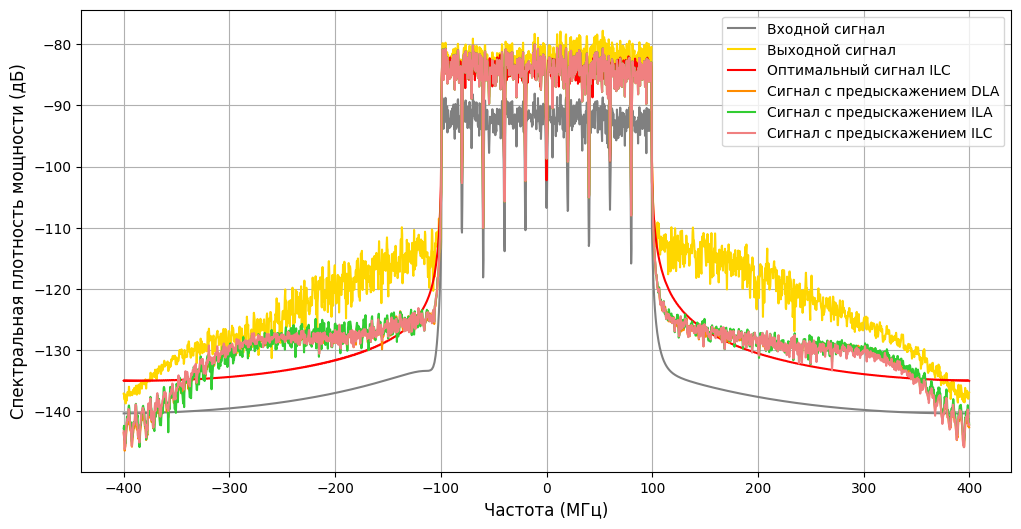

In [36]:
# построение спектра

xlabel="Частота (МГц)"
ylabel= "Спектральная плотность мощности (дБ)"
fontsize = 12
figsize=(12, 6)

plt.figure(figsize=figsize)

plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_in)), color='grey', label='Входной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_pa)), color='gold', label='Выходной сигнал')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa)), color='red', label='Оптимальный сигнал ILC')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_dla)), color='darkorange', label='Сигнал с предыскажением DLA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_ila)), color='limegreen', label='Сигнал с предыскажением ILA')
plt.plot(freqs / 1e6, 10 * np.log10(np.abs(spectrum_y_val_ilc)), color='lightcoral', label='Сигнал с предыскажением ILC')


plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()



In [37]:
# moving_average
window_size = 60

freqs_s, spectrum_y_in_s = utils.moving_average(spectrum_y_in, freqs, fs, window_size)
_, spectrum_y_out_s = utils.moving_average(spectrum_y_out, freqs, fs, window_size)
_, spectrum_y_val_pa_s = utils.moving_average(spectrum_y_val_pa, freqs, fs, window_size)
_, spectrum_y_val_target_s = utils.moving_average(spectrum_y_val_target, freqs, fs, window_size)

# _, spectrum_y_val_dla_s = utils.moving_average(spectrum_y_val_dla, freqs, fs, window_size)
# _, spectrum_y_val_ila_s = utils.moving_average(spectrum_y_val_ila, freqs, fs, window_size)
# _, spectrum_y_dpd_ilc_grad_s = utils.moving_average(spectrum_y_dpd_ilc_grad, freqs, fs, window_size)

_, spectrum_y_val_dla_s = utils.moving_average(spectrum_y_val_dla, freqs, fs, window_size)
_, spectrum_y_val_ila_s = utils.moving_average(spectrum_y_val_ila, freqs, fs, window_size)
_, spectrum_y_val_ilc_s = utils.moving_average(spectrum_y_val_ilc, freqs, fs, window_size)

_, spectrum_u_k_s = utils.moving_average(spectrum_u_k, freqs, fs, window_size)
_, spectrum_u_k_pa_s = utils.moving_average(spectrum_u_k_pa, freqs, fs, window_size)



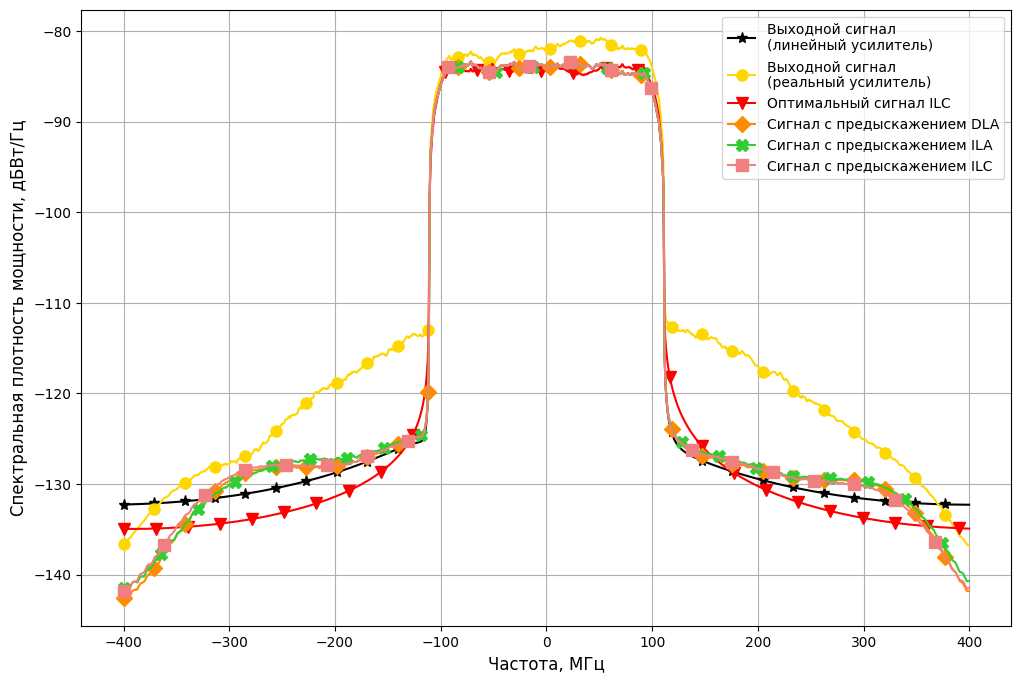

In [38]:
# (сглаженный) построение спектра

xlabel="Частота, МГц"
ylabel= "Спектральная плотность мощности, дБВт/Гц"
fontsize = 12
figsize=(12, 8)
markersize=8

plt.figure(figsize=figsize)

# plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_in_s)), 
#          color='grey', label='Входной сигнал',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_target_s)), 
         color='black', label='Выходной сигнал\n(линейный усилитель)',marker = '*', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_pa_s)), 
         color='gold', label='Выходной сигнал\n(реальный усилитель)', marker='o', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_u_k_pa_s)), 
         color='red', label='Оптимальный сигнал ILC', marker='v', markevery=95, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_dla_s)), 
         color='darkorange', label='Сигнал с предыскажением DLA', marker='D', markevery=90, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_ila_s)), 
         color='limegreen', label='Сигнал с предыскажением ILA', marker='X', markevery=110, markersize=markersize)
plt.plot(freqs_s / 1e6, 10 * np.log10(np.abs(spectrum_y_val_ilc_s)), 
         color='lightcoral', label='Сигнал с предыскажением ILC', marker='s', markevery=120, markersize=markersize)

plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.legend()
plt.grid()
plt.show()


AM/AM & AM/PM

In [39]:
y_in_am_am, y_out_am_am = metrics.calculate_am_am(x_val, y_val)
y_in_am_pm, y_in_phase_am_pm = metrics.calculate_am_pm(x_val, y_val)

_, y_pa_am_am = metrics.calculate_am_am(x_val, y_val_pa)
_, y_pa_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_pa)

_, y_val_target_am_am = metrics.calculate_am_am(x_val, y_val_target)
_, y_val_target_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_target)

# x_in_am_am, u_k_am_am = metrics.calculate_am_am(x_train, u_k)
# x_in_am_pm, u_k_phase_am_pm = metrics.calculate_am_pm(x_train, u_k)

# _, u_k_pa_am_am = metrics.calculate_am_am(x_train, u_k_pa)
# _, u_k_pa_phase_am_pm = metrics.calculate_am_pm(x_train, u_k_pa)

#linearized
_, y_val_dla_am_am = metrics.calculate_am_am(x_val, y_val_dla)
_, y_val_dla_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_dla)

_, y_val_ila_am_am = metrics.calculate_am_am(x_val, y_val_ila)
_, y_val_ila_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_ila)

_, y_val_ilc_am_am = metrics.calculate_am_am(x_val, y_val_ilc)
_, y_val_ilc_phase_am_pm = metrics.calculate_am_pm(x_val, y_val_ilc)


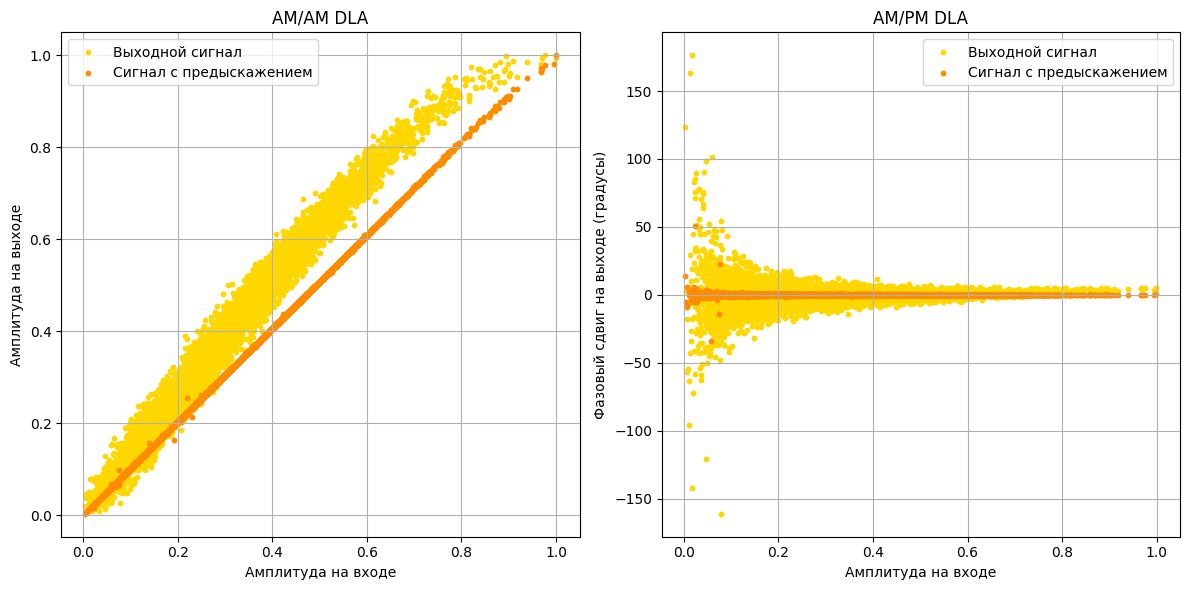

In [40]:
#DLA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_val_dla_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_val_dla_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_val_dla_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM DLA", "AM/PM DLA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)



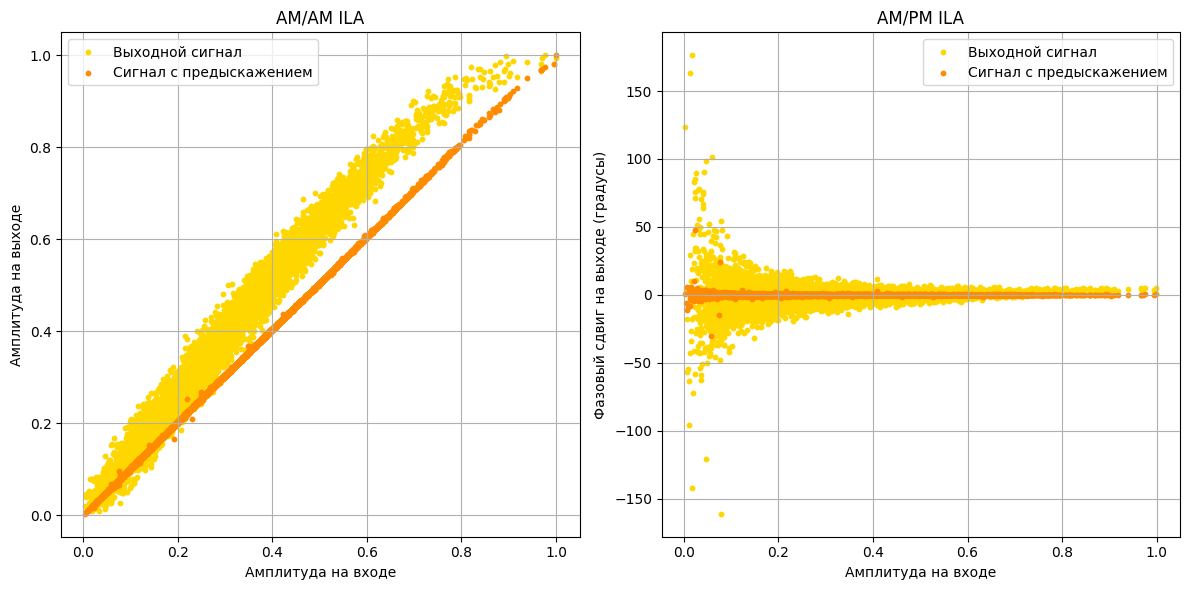

In [41]:
#ILA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_val_ila_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_val_ila_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_val_ila_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILA", "AM/PM ILA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


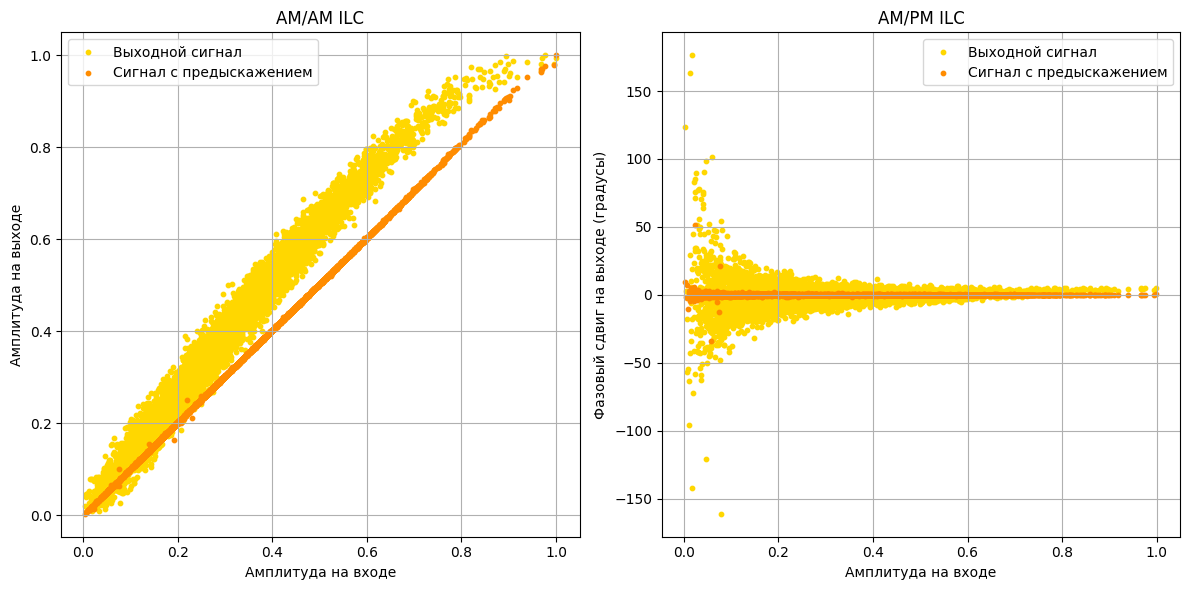

In [42]:
#ILC

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ilc_grad_am_am, 'magenta', 'Сигнал на выходе корректора'),
    (y_in_am_am, y_val_ilc_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_val_ilc_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILC", "AM/PM ILC"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


Add noise

In [52]:
snr_range = list(range(20, 61, 5))

epochs = 500
lr = 0.01
num_realizations = 500

snr_params = params.make_snr_params(
    snr_range=snr_range,
    num_realizations=num_realizations,
    fs=fs,
    bw_main_ch=bw_main_ch,
    epochs=epochs,
    learning_rate=lr,
    acpr_meter=acpr_meter,
    pa_model=pa_model,
    gain=gain
)

gmp_degree = 5
gmp_params = {"gmp_degree": gmp_degree}

snr_metrics_runner = pipelines.SnrPipeline(base_model=GMP, 
                                           input_model_params=gmp_params, 
                                           data_dict=data, 
                                           snr_params=snr_params)

In [53]:
snr_metrics_runner.run(arch_name="DLA")

SNR: 20
===Start training===
Epoch 0000 — train_loss: 0.378711, val_loss: 0.516984, val_NMSE: -1.79
Epoch 0100 — train_loss: 0.014913, val_loss: 0.015251, val_NMSE: -17.09
Epoch 0200 — train_loss: 0.014888, val_loss: 0.015069, val_NMSE: -17.14
Epoch 0300 — train_loss: 0.014815, val_loss: 0.015087, val_NMSE: -17.14
Epoch 0400 — train_loss: 0.014569, val_loss: 0.014973, val_NMSE: -17.17
Epoch 0499 — train_loss: 0.014491, val_loss: 0.014971, val_NMSE: -17.17
Время обучения: 0:02:07
===Training complete===
SNR: 25
===Start training===
Epoch 0000 — train_loss: 0.381326, val_loss: 0.498990, val_NMSE: -1.94
Epoch 0100 — train_loss: 0.004938, val_loss: 0.005082, val_NMSE: -21.86
Epoch 0200 — train_loss: 0.004860, val_loss: 0.004920, val_NMSE: -22.00
Epoch 0300 — train_loss: 0.004767, val_loss: 0.004979, val_NMSE: -21.95
Epoch 0400 — train_loss: 0.004833, val_loss: 0.004956, val_NMSE: -21.97
Epoch 0499 — train_loss: 0.004820, val_loss: 0.004888, val_NMSE: -22.03
Время обучения: 0:02:06
===Train

In [54]:
snr_metrics_runner.run(arch_name="ILA")

SNR: 20
===Start training===
Epoch 0000 — train_loss: 0.059848, val_loss: 0.081936, val_NMSE: -1.76
Epoch 0100 — train_loss: 0.001612, val_loss: 0.001666, val_NMSE: -18.67
Epoch 0200 — train_loss: 0.001570, val_loss: 0.001626, val_NMSE: -18.78
Epoch 0300 — train_loss: 0.001572, val_loss: 0.001608, val_NMSE: -18.83
Epoch 0400 — train_loss: 0.001557, val_loss: 0.001562, val_NMSE: -18.95
Epoch 0499 — train_loss: 0.001543, val_loss: 0.001567, val_NMSE: -18.94
Время обучения: 0:01:14
===Training complete===
SNR: 25
===Start training===
Epoch 0000 — train_loss: 0.059314, val_loss: 0.097127, val_NMSE: -1.02
Epoch 0100 — train_loss: 0.000611, val_loss: 0.000626, val_NMSE: -22.92
Epoch 0200 — train_loss: 0.000581, val_loss: 0.000595, val_NMSE: -23.14
Epoch 0300 — train_loss: 0.000569, val_loss: 0.000595, val_NMSE: -23.15
Epoch 0400 — train_loss: 0.000564, val_loss: 0.000592, val_NMSE: -23.17
Epoch 0499 — train_loss: 0.000557, val_loss: 0.000590, val_NMSE: -23.18
Время обучения: 0:01:14
===Train

In [55]:
snr_metrics_runner.run(arch_name="ILC")

SNR: 20
Epoch [0/500], Loss: 0.05481655150651932
Epoch [100/500], Loss: 0.018765931949019432
Epoch [200/500], Loss: 0.014988327398896217
Epoch [300/500], Loss: 0.014843262732028961
Epoch [400/500], Loss: 0.014706596732139587
Epoch [499/500], Loss: 0.014754110015928745
Время расчёта ilc_signal: 0:01:14
===Start training===
Epoch 0000 — train_loss: 0.035044, val_loss: 0.028912, val_NMSE: -3.81
Epoch 0100 — train_loss: 0.000031, val_loss: 0.000031, val_NMSE: -33.49
Epoch 0200 — train_loss: 0.000021, val_loss: 0.000020, val_NMSE: -35.31
Epoch 0300 — train_loss: 0.000018, val_loss: 0.000018, val_NMSE: -35.93
Epoch 0400 — train_loss: 0.000017, val_loss: 0.000017, val_NMSE: -36.21
Epoch 0499 — train_loss: 0.000016, val_loss: 0.000016, val_NMSE: -36.35
Время обучения: 0:00:58
===Training complete===
SNR: 25
Epoch [0/500], Loss: 0.03817254304885864
Epoch [100/500], Loss: 0.006577697116881609
Epoch [200/500], Loss: 0.004973146133124828
Epoch [300/500], Loss: 0.004793424159288406
Epoch [400/500],

In [56]:
results = snr_metrics_runner.get_results()

snr_range = results["snr_range"]

nmse_dla_list = results["dla"]["nmse"]
acpr_left_dla_list = results["dla"]["acpr_left"]
acpr_right_dla_list = results["dla"]["acpr_right"]

nmse_ila_list = results["ila"]["nmse"]
acpr_left_ila_list = results["ila"]["acpr_left"]
acpr_right_ila_list = results["ila"]["acpr_right"]

nmse_ilc_list = results["ilc"]["nmse"]
acpr_left_ilc_list = results["ilc"]["acpr_left"]
acpr_right_ilc_list = results["ilc"]["acpr_right"]

nmse_uk_list = results["uk"]["nmse"]
acpr_left_uk_list = results["uk"]["acpr_left"]
acpr_right_uk_list = results["uk"]["acpr_right"]

In [57]:
print(f"snr_range = {snr_range}")
print()

print(f"nmse_dla_list = {(nmse_dla_list)}")
print(f"acpr_left_dla_list = {acpr_left_dla_list}")
print(f"acpr_right_dla_list = {acpr_right_dla_list}")
print()

print(f"nmse_ila_list = {nmse_ila_list}")
print(f"acpr_left_ila_list = {acpr_left_ila_list}")
print(f"acpr_right_ila_list = {acpr_right_ila_list}")
print()

print(f"nmse_ilc_list = {nmse_ilc_list}")
print(f"acpr_left_ilc_list = {acpr_left_ilc_list}")
print(f"acpr_right_ilc_list = {acpr_right_ilc_list}")
print()

print(f"nmse_uk_list = {nmse_uk_list}")
print(f"acpr_left_uk_list = {acpr_left_uk_list}")
print(f"acpr_right_uk_list = {acpr_right_uk_list}")

snr_range = [20, 25, 30, 35, 40, 45, 50, 55, 60]

nmse_dla_list = [-17.148632049560547, -22.024913787841797, -26.938125610351562, -31.83021354675293, -36.51686096191406, -40.62764358520508, -43.64088821411133, -45.28367233276367, -45.97032928466797]
acpr_left_dla_list = [np.float64(-20.02928768602456), np.float64(-24.982584759640396), np.float64(-29.94026217788973), np.float64(-34.790795872739075), np.float64(-39.38424284115534), np.float64(-43.27951405106335), np.float64(-45.91862097413965), np.float64(-47.333822464193716), np.float64(-47.83152138893719)]
acpr_right_dla_list = [np.float64(-20.042172905027773), np.float64(-25.000703280641286), np.float64(-29.94555560855832), np.float64(-34.80382540388212), np.float64(-39.38523604062279), np.float64(-43.28755626930241), np.float64(-45.98511389366253), np.float64(-47.36026912001858), np.float64(-47.90736568475759)]

nmse_ila_list = [-16.83725929260254, -21.696548461914062, -26.669509887695312, -31.488346099853516, -36.02500915527344, -39

In [ ]:
# # значения в виде списков чтобы не рассчитывать снова все значения

# snr_range = [20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60]

# nmse_dla_list = [-17.154949188232422, -19.09251594543457, -21.044750213623047, -23.021923065185547, -25.002155303955078, -26.98126983642578, -28.954303741455078, -30.937488555908203, -32.90107345581055, -34.845218658447266, -36.755924224853516, -38.61607360839844, -40.426910400390625, -42.124752044677734, -43.687843322753906, -45.075897216796875, -46.248626708984375, -47.228172302246094, -47.92564010620117, -48.49229431152344, -48.84376907348633]
# acpr_left_dla_list = [np.float64(-20.032896621274734), np.float64(-22.002898276331), np.float64(-23.980167111262954), np.float64(-25.985284041461938), np.float64(-27.943916970011372), np.float64(-29.91541877521779), np.float64(-31.871352771576074), np.float64(-33.797012660383636), np.float64(-35.67219414298505), np.float64(-37.49542101433636), np.float64(-39.210372332336746), np.float64(-40.8129737284458), np.float64(-42.2611022976035), np.float64(-43.489963007240796), np.float64(-44.48969779871533), np.float64(-45.26628275458397), np.float64(-45.82507862711507), np.float64(-46.26964161953022), np.float64(-46.544344312319446), np.float64(-46.7247453176207), np.float64(-46.8625007497271)]
# acpr_right_dla_list = [np.float64(-20.03067217721715), np.float64(-22.023901072994782), np.float64(-23.999487986191852), np.float64(-25.990288997195552), np.float64(-27.97879723510448), np.float64(-29.93405882623138), np.float64(-31.885189566353002), np.float64(-33.83402270942291), np.float64(-35.73882672394366), np.float64(-37.591940638042516), np.float64(-39.35400356485398), np.float64(-41.02262823000135), np.float64(-42.529186070031216), np.float64(-43.87146478243156), np.float64(-44.98060385142986), np.float64(-45.87641689390573), np.float64(-46.57500010862354), np.float64(-47.01434234515064), np.float64(-47.360535320706695), np.float64(-47.54855205738099), np.float64(-47.716042344669965)]

# nmse_ila_list = [-17.14900016784668, -19.082727432250977, -21.0418701171875, -23.009443283081055, -24.970191955566406, -26.952104568481445, -28.929380416870117, -30.873485565185547, -32.79220199584961, -34.68447494506836, -36.50259017944336, -38.23097229003906, -39.86079025268555, -41.318084716796875, -42.59962463378906, -43.62651062011719, -44.414581298828125, -45.008975982666016, -45.430274963378906, -45.73917007446289, -45.99494552612305]
# acpr_left_ila_list = [np.float64(-20.023492672712504), np.float64(-22.00194266264846), np.float64(-23.982589695597863), np.float64(-25.971010353814368), np.float64(-27.954582475654398), np.float64(-29.883061513651946), np.float64(-31.84119207223084), np.float64(-33.741020731136594), np.float64(-35.59542076282507), np.float64(-37.389910008838555), np.float64(-39.05389357257544), np.float64(-40.57882064420808), np.float64(-41.87301807298115), np.float64(-43.028623797072676), np.float64(-43.97164913381233), np.float64(-44.47478498942156), np.float64(-45.094347042181134), np.float64(-45.44431979439592), np.float64(-45.6689972060291), np.float64(-45.81347702948893), np.float64(-45.919890365450364)]
# acpr_right_ila_list = [np.float64(-20.037619673095683), np.float64(-22.02154157779769), np.float64(-24.00141855357515), np.float64(-25.97407114783849), np.float64(-27.954493059455036), np.float64(-29.931848642514495), np.float64(-31.87500171448285), np.float64(-33.78634424089804), np.float64(-35.682854215253045), np.float64(-37.49031966564913), np.float64(-39.21893888309752), np.float64(-40.82172035769772), np.float64(-42.24376419843244), np.float64(-43.494933171804725), np.float64(-44.48705283113159), np.float64(-45.28125077526404), np.float64(-45.82150567692158), np.float64(-46.23586524416965), np.float64(-46.483727735029944), np.float64(-46.80989034343764), np.float64(-46.76467487891643)]

# nmse_ilc_list = [-17.161582946777344, -19.08861541748047, -21.052515029907227, -23.02472496032715, -25.0006103515625, -26.98052978515625, -28.957475662231445, -30.93657875061035, -32.8939208984375, -34.8338737487793, -36.754276275634766, -38.548091888427734, -40.303565979003906, -41.94981002807617, -43.43807601928711, -44.752685546875, -45.811702728271484, -46.68809509277344, -47.2928581237793, -47.732051849365234, -48.105037689208984]
# acpr_left_ilc_list = [np.float64(-20.04499601993586), np.float64(-22.000575773262312), np.float64(-24.005173164637622), np.float64(-25.975381528613166), np.float64(-27.948773007731976), np.float64(-29.904547380654257), np.float64(-31.83497348292303), np.float64(-33.76508347209344), np.float64(-35.63135714041884), np.float64(-37.43372467772184), np.float64(-39.14673797702895), np.float64(-40.682020346354115), np.float64(-42.074796748562314), np.float64(-43.25955583198558), np.float64(-44.172655984033355), np.float64(-44.92677486420471), np.float64(-45.42858744174152), np.float64(-45.81765459787905), np.float64(-46.0679249887625), np.float64(-46.22621768342928), np.float64(-46.348104813507604)]
# acpr_right_ilc_list = [np.float64(-20.055033821205793), np.float64(-22.02296109860739), np.float64(-24.011375645858735), np.float64(-25.989965909004713), np.float64(-27.974052697082097), np.float64(-29.94138650953073), np.float64(-31.89681741205028), np.float64(-33.840142017577605), np.float64(-35.730656379008416), np.float64(-37.598354712999864), np.float64(-39.381993008609946), np.float64(-41.00939897421255), np.float64(-42.49628648885533), np.float64(-43.81904566125652), np.float64(-44.926036747000865), np.float64(-45.77697004484083), np.float64(-46.456832260637114), np.float64(-46.9203740307759), np.float64(-47.219135964704975), np.float64(-47.42920449390439), np.float64(-47.62513932513492)]

# nmse_uk_list = [-17.094663619995117, -19.016490936279297, -20.960582733154297, -22.905410766601562, -24.86489486694336, -26.823619842529297, -28.778156280517578, -30.729806900024414, -32.679481506347656, -34.633670806884766, -36.5738410949707, -38.51299285888672, -40.44480514526367, -42.37684631347656, -44.29717254638672, -46.236045837402344, -48.150821685791016, -50.04896926879883, -51.969764709472656, -53.85963439941406, -55.72507858276367]
# acpr_left_uk_list = [np.float64(-19.99438441289194), np.float64(-21.9658512665871), np.float64(-23.945869167743208), np.float64(-25.92128162743692), np.float64(-27.9018250793472), np.float64(-29.857668613519994), np.float64(-31.830175197925897), np.float64(-33.76021792312188), np.float64(-35.677025441911994), np.float64(-37.586095603435375), np.float64(-39.42729918519659), np.float64(-41.22707557884934), np.float64(-42.936348574753275), np.float64(-44.508877373457345), np.float64(-45.93217114866118), np.float64(-47.16637553054871), np.float64(-48.16740369704331), np.float64(-48.992740555776834), np.float64(-49.56517529961033), np.float64(-50.01273812436431), np.float64(-50.31230743627908)]
# acpr_right_uk_list = [np.float64(-19.908159326520842), np.float64(-21.85695263610488), np.float64(-23.818630432812846), np.float64(-25.74280605561588), np.float64(-27.685123164021324), np.float64(-29.597578780431057), np.float64(-31.50956145186845), np.float64(-33.408043631235536), np.float64(-35.2641539488935), np.float64(-37.11290256809776), np.float64(-38.87993901305795), np.float64(-40.61697803065708), np.float64(-42.25138725427255), np.float64(-43.7730148204967), np.float64(-45.139205723386205), np.float64(-46.40286494928455), np.float64(-47.41226707888618), np.float64(-48.2239296586826), np.float64(-48.8718445889375), np.float64(-49.305717773680755), np.float64(-49.67857146555004)]

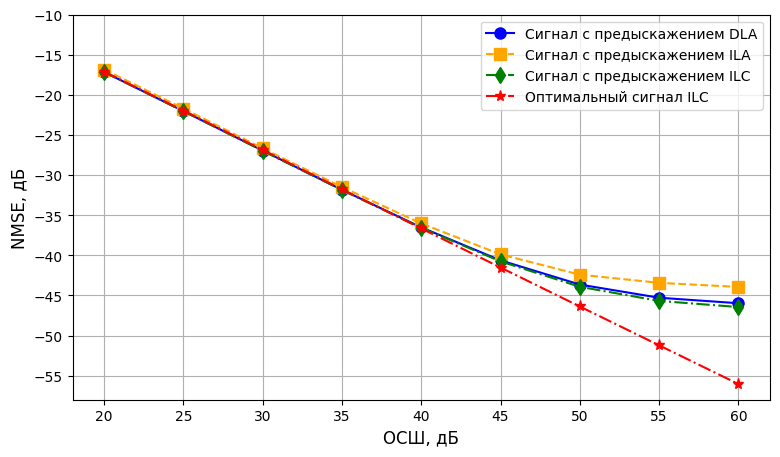

In [58]:
markersize = 8
plt.figure(figsize=(9, 5))
plt.plot(snr_range, nmse_dla_list,color='blue', linestyle='-', label="Сигнал с предыскажением DLA",
         marker='o', markersize=markersize)
plt.plot(snr_range, nmse_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA",
         marker='s', markersize=markersize)
plt.plot(snr_range, nmse_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC",
         marker='d', markersize=markersize)
plt.plot(snr_range, nmse_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC",
         marker='*', markersize=markersize)

plt.xlabel("ОСШ, дБ", fontsize=12)
plt.ylabel("NMSE, дБ", fontsize=12)
# plt.title("Зависимость NMSE от ОСШ")
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -9, 5))
plt.legend()
plt.grid(True)

plt.show()


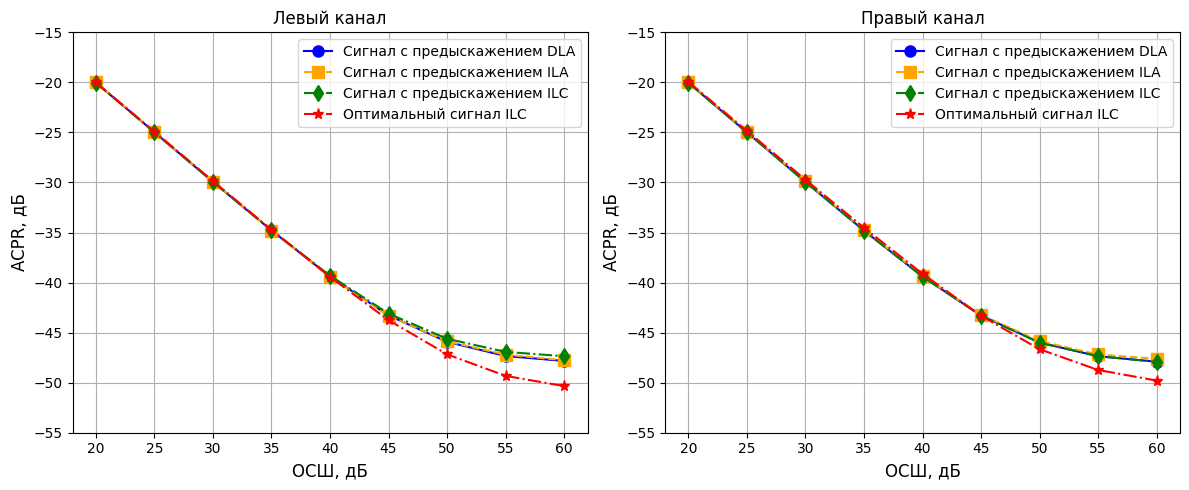

In [59]:
markersize=8
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(snr_range, acpr_left_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_left_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_left_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_left_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Левый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, acpr_right_dla_list, color='blue', linestyle='-', label="Сигнал с предыскажением DLA", 
         marker='o', markersize=markersize)
plt.plot(snr_range, acpr_right_ila_list, color='orange', linestyle='--', label="Сигнал с предыскажением ILA", 
         marker='s', markersize=markersize)
plt.plot(snr_range, acpr_right_ilc_list, color='green', linestyle='-.', label="Сигнал с предыскажением ILC", 
         marker='d', markersize=markersize)
plt.plot(snr_range, acpr_right_uk_list, color='red', linestyle='-.', label="Оптимальный сигнал ILC", 
         marker='*', markersize=markersize)
plt.title('Правый канал', fontsize=12)
plt.xlabel('ОСШ, дБ', fontsize=12)
plt.ylabel('ACPR, дБ', fontsize=12)
plt.xticks(range(20, 61, 5))
plt.yticks(range(-55, -14, 5))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()